
# Urban Sound Classification - Salamon and Bello Implementation

- Salamon and Bello, in their 2016 IEEE Signal Processing paper attempted to classify Urban Sounds to their sources using a Convolutional Neural Network (CNN) - Impact Factor: 3.105


- To extend the UrbanSound8K dataset, they applied Data-Augmentation techniques: Pitch Shift, Time Stretch, Noise addition, and Dynamic Sound Compression.


- For training, they converted their sound-clips to log scaled mel-spectrograms.


- The augmentation resulted in a significant increase in accuracy.


### Objectives

- Implement Salamon and Bello’s Urban Sound Classification Convolutional Neural Network

- Apply Data-Augmentation on the default UrbanSound8K dataset and compare the results

- Deploy the model as a containerized Web-App for users to access


## Mounting Drive

In [ ]:
# mount drive with data
from google.colab import drive
drive.mount('/content/gdrive')
# data download link - https://goo.gl/8hY5ER

Mounted at /content/gdrive


## Importing Libraries

In [ ]:
# librosa for sound processing
!pip install librosa==0.7.2

# for augmentation
!pip install pyrubberband

# seaborn
!pip install seaborn==0.10.0

#numba
!pip install numba==0.48

In [ ]:
# importing libraries
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow import keras
import numpy as np
import pandas as pd
import librosa.display
from tqdm import tqdm
import pickle as pkl

import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

import pyrubberband as pyrb
import re
import six
from copy import deepcopy

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils
from keras.regularizers import l2
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout

## Setting Hyperparameters

In [ ]:
# Hyperparameters
window_size = 507
frames = 128
bands = 128

## Data Preprocessing

In [ ]:
path = '/content/gdrive/My Drive/'

In [ ]:
metadata = pd.read_csv("/content/gdrive/My Drive/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head()

In [ ]:
#preprocessing using entire feature set
path="/content/gdrive/My Drive/UrbanSound8K/audio/fold"
processed_data = {}

for i in tqdm(range(len(metadata))):
    fold_no = str(metadata.iloc[i]["fold"])
    file = metadata.iloc[i]["slice_file_name"]
    label = metadata.iloc[i]["classID"]
    filename = path + fold_no + "/" + file
    sound_clip, sr = librosa.load(filename)
    if (sound_clip.shape[0] // window_size < 128):
      continue
    log_specgrams = []
    start = 0
    for no_frames in range(128):
      end = start + window_size
      if(len(sound_clip[start:end]) == int(window_size)):
          signal = sound_clip[start:end]
          melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
          logspec = librosa.amplitude_to_db(melspec)
          logspec = logspec.T.flatten()[:, np.newaxis].T
          log_specgrams.append(logspec)
      start = end
    log_specgrams = np.asarray(log_specgrams).reshape(frames,bands,1)
    if processed_data.get(fold_no) == None:
      processed_data[fold_no] = []
    processed_data[fold_no].append((log_specgrams, label))

In [ ]:
# with open("/content/gdrive/My Drive/UrbanSound8K/processed_data.pickle","wb") as f:
#   pkl.dump(processed_data,f)

## Augmentation

In [ ]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath(path + '/UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
augmented_path = os.path.join(audio_path, 'augmented')

# Metadata
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
metadata_augmented_path = os.path.abspath(path + 'data/augmented-data.csv')

In [ ]:
# Load the metadata from the generated CSV
metadata = pd.read_csv("/content/gdrive/My Drive/UrbanSound8K/metadata/UrbanSound8K.csv")

# Examine dataframe
metadata.head()


### Time Stretching

In [ ]:
# print(librosa.__version__)
import soundfile as sf

In [ ]:
# preprocessing and augmenting using entire feature set
path="/content/gdrive/My Drive/UrbanSound8K/audio/fold"

rates = [0.9, 0, 1.1]
augmented_time_stretched_data = {}

for i in tqdm(range(len(metadata))):
    fold_no = str(metadata.iloc[i]["fold"])
    file = metadata.iloc[i]["slice_file_name"]
    label = metadata.iloc[i]["classID"]
    filename = path + fold_no + "/" + file
    y, sr = librosa.load(filename)
    if (y.shape[0] // window_size < 128):
      continue

    # time stretching
    for rate in rates:
      if rate == 0:
        sound_clip = y
      else:
        sound_clip = librosa.effects.time_stretch(y, rate = rate)
      log_specgrams = []
      start = 0
      for no_frames in range(128):
        end = start + window_size
        if(len(sound_clip[start:end]) == int(window_size)):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec = librosa.amplitude_to_db(melspec)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
        start = end
      log_specgrams = np.asarray(log_specgrams).reshape(frames,bands,1)
      if augmented_time_stretched_data.get(fold_no) == None:
        augmented_time_stretched_data[fold_no] = []
      augmented_time_stretched_data[fold_no].append((log_specgrams, label))

### Pitch Shifting

In [ ]:
# preprocessing and augmenting using entire feature set
path="/content/gdrive/My Drive/UrbanSound8K/audio/fold"
tone_steps = [-2, 0, 2]
augmented_pitch_shifted_data = {}
for i in tqdm(range(len(metadata))):
    fold_no = str(metadata.iloc[i]["fold"])
    file = metadata.iloc[i]["slice_file_name"]
    label = metadata.iloc[i]["classID"]
    filename = path + fold_no + "/" + file
    y, sr = librosa.load(filename)
    if (y.shape[0] // window_size < 128):
      continue
    # pitch shifting
    for tone_step in tone_steps:
      if tone_step == 0:
        sound_clip = y
      else:
        sound_clip = librosa.effects.pitch_shift(y, sr, n_steps = tone_step)
      log_specgrams = []
      start = 0
      for no_frames in range(128):
        end = start + window_size
        if(len(sound_clip[start:end]) == int(window_size)):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec = librosa.amplitude_to_db(melspec)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
        start = end
      log_specgrams = np.asarray(log_specgrams).reshape(frames,bands,1)
      if augmented_pitch_shifted_data.get(fold_no) == None:
        augmented_pitch_shifted_data[fold_no] = []
      augmented_pitch_shifted_data[fold_no].append((log_specgrams, label))

### Noise Addition

In [ ]:
def add_noise(data):
    noise = np.random.rand(len(data))
    noise = np.ones(len(data))
    noise_amp = np.random.uniform(0.005, 0.008)
    data_noise = data + (noise_amp * noise)
    return data_noise

In [ ]:
total = len(metadata)
count = 0
augmented_path = "/content/gdrive/My Drive/UrbanSound8K/"
path="/content/gdrive/My Drive/UrbanSound8K/audio/fold"
# Generate new noised audio
for index, row in metadata.iterrows():
    curr_fold = str(row['fold'])
    curr_file_path = path + curr_fold + '/' + row['slice_file_name']

    # Noised sub-dir inside current fold dir
    curr_noise_path = augmented_path

    # Create sub-dir if it does not exist
    if not os.path.exists(curr_noise_path):
        os.makedirs(curr_noise_path)
        
    output_path = curr_noise_path + '/' + row['slice_file_name']
        
    # Skip when file already exists
    if (os.path.isfile(output_path)):
        count += 1 
        continue
        
    y, sr = librosa.load(curr_file_path)  
    y_changed = add_noise(y)
    librosa.output.write_wav(output_path, y_changed, sr)
    
    count += 1 

    clear_output(wait=True)
    print("Progress: {}/{}".format(count, total))
    print("Last file: ", row['slice_file_name'])

In [ ]:
# with open("/content/gdrive/My Drive/UrbanSound8K/augmented_data.pickle","wb") as f:
#   pkl.dump(processed_data,f)

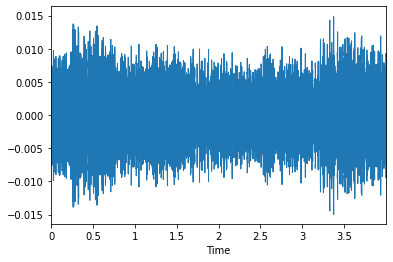

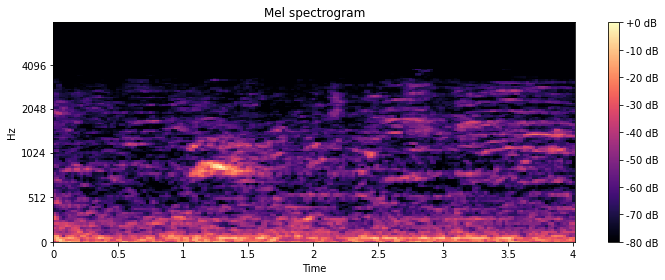

In [ ]:
filename = path + "5" + "/" + "100263-2-0-137.wav"
y, sr = librosa.load(filename)
librosa.display.waveplot(y, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

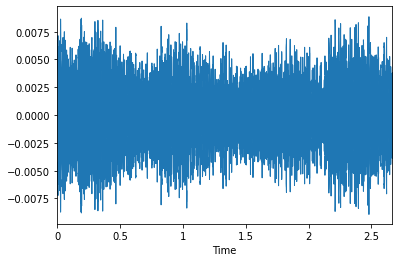

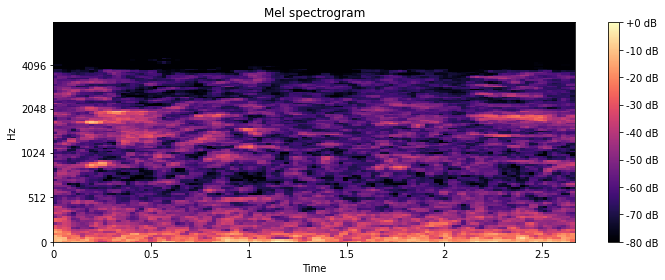

In [ ]:
sound_clip = librosa.effects.time_stretch(y, rate = 1.5)
librosa.display.waveplot(sound_clip, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

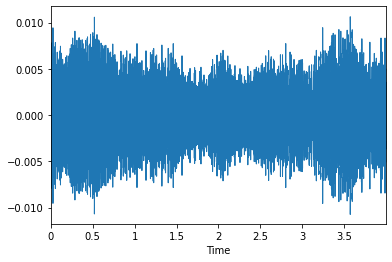

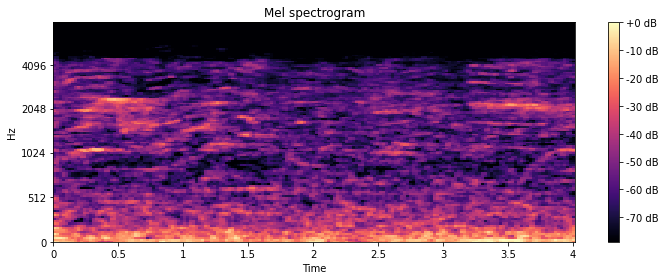

In [ ]:
sound_clip = librosa.effects.pitch_shift(y, sr, n_steps = 3.5)
librosa.display.waveplot(sound_clip, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

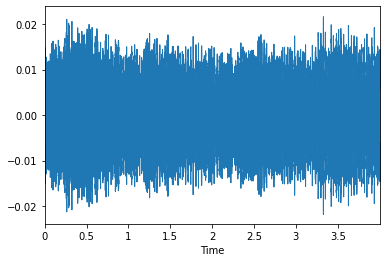

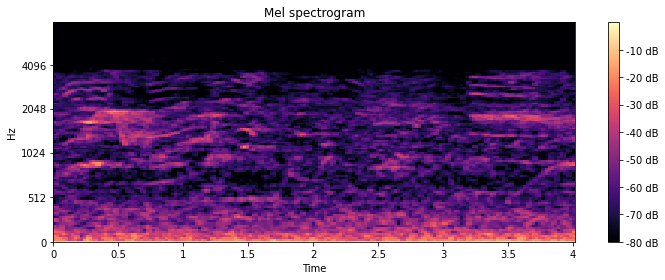

In [ ]:
sound_clip = add_noise(y)
librosa.display.waveplot(sound_clip, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## CNN Model

### Original model 



### Model in Updated Keras

In [ ]:
# paper model translated
def build_model_3():
  #forming model
  model=Sequential()

  #adding layers and forming the model
  model.add(Conv2D(24,kernel_size=5,strides=1,padding="Same",input_shape=(bands, frames, 1)))
  model.add(MaxPooling2D(pool_size = (4,2)))
  model.add(Activation('relu'))

  model.add(Conv2D(48,kernel_size=5,strides=1,padding="same"))
  model.add(MaxPooling2D(pool_size = (4,2)))
  model.add(Activation('relu'))

  model.add(Conv2D(48,kernel_size=5,strides=1,padding="same"))
  model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(64,activity_regularizer=l2(0.001)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10,activity_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Activation('softmax'))

  #compiling
  model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

  return model

In [ ]:
def get_accuracy(testing_results, data_type):
  if data_type == "default":
    with open("/content/gdrive/My Drive/UrbanSound8K/default_accuracies.pickle","rb") as f:
      accuracies = pkl.load(f)
  else:
    with open("/content/gdrive/My Drive/UrbanSound8K/aug_accuracies.pickle","rb") as f:
      accuracies = pkl.load(f)
  return accuracies

# Training and Testing using Default Data

### Data generation from default preprocessed data

In [ ]:
with open("/content/gdrive/My Drive/UrbanSound8K/processed_data.pickle","rb") as f:
  processed_data = pkl.load(f)

In [ ]:
def pre_process(i):
  xtrain = []
  ytrain = []
  xtest = []
  ytest = []
  # Folder 10 is test rest is train for now
  for key in processed_data.keys():
    if key==str(i):
      for data in processed_data[key]:
        xtest.append(data[0])
        ytest.append(data[1])
    else:
      for data in processed_data[key]:
        xtrain.append(data[0])
        ytrain.append(data[1])
    
  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  ytrain = to_categorical(ytrain)
  ytest = to_categorical(ytest)

  return xtrain, xtest, ytrain, ytest

In [ ]:
model = build_model_3()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 24)      624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 24)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 64, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 48)        28848     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 48)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 8, 32, 48)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 48)         5

### Training

In [ ]:
# trained on self
for i in range(10,11):
  xtrain, xtest, ytrain, ytest = pre_process(10)
  model = build_model_3()
  if i==10:
    model.summary()
  model.fit(xtrain, ytrain, validation_data = (xtest, ytest), batch_size=100, epochs=50)
  print("#"*100)
  print()

## Saving and Loading

In [ ]:
# model.save_weights("/content/gdrive/My Drive/sound_model_default_weights.h5")

In [ ]:
dnew_model = build_model_3()
dnew_model.load_weights("/content/gdrive/My Drive/sound_model_default_weights.h5")

## Testing

In [ ]:
def process_test_point(file_path):
  sound_clip, sr = librosa.load(file_path)
  if (sound_clip.shape[0] // window_size < 128):
    return "Audio file too short to make a prediction!"
  log_specgrams = []
  start = 0
  for no_frames in range(128):
    end = start + window_size
    if(len(sound_clip[start:end]) == int(window_size)):
        signal = sound_clip[start:end]
        melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
        logspec = librosa.amplitude_to_db(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        log_specgrams.append(logspec)
    start = end
  log_specgrams = np.asarray(log_specgrams).reshape(frames,bands,1)
  return log_specgrams

In [ ]:
testing_results = dnew_model.predict_classes(xtest)
default_accuracy = get_accuracy(testing_results, "default")

# Training and Testing using Augmented Data

### Data generation from augmented data

In [ ]:
with open("/content/gdrive/My Drive/UrbanSound8K/augmented_data.pickle","rb") as f:
  augmented_data = pkl.load(f)

In [ ]:
def pre_process(i):
  xtrain = []
  ytrain = []
  xtest = []
  ytest = []
  # Folder 10 is test rest is train for now
  for key in augmented_data.keys():
    if key==str(i):
      for data in augmented_data[key]:
        xtest.append(data[0])
        ytest.append(data[1])
    else:
      for data in augmented_data[key]:
        xtrain.append(data[0])
        ytrain.append(data[1])
    
  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  ytrain = to_categorical(ytrain)
  ytest = to_categorical(ytest)

  return xtrain, xtest, ytrain, ytest

### Training on Augmented Data

In [ ]:
# trained on self
for i in range(10,11):
  xtrain, xtest, ytrain, ytest = pre_process(10)
  model = build_model_3()
  if i==10:
    model.summary()
  model.fit(xtrain, ytrain, validation_data = (xtest, ytest), batch_size=100, epochs=50)
  print("#"*100)
  print()

## Saving and Loading

In [ ]:
# model.save_weights("/content/gdrive/My Drive/sound_model_aug_weights.h5")

In [ ]:
new_model = build_model_3()
new_model.load_weights("/content/gdrive/My Drive/sound_model_aug_weights.h5")

## Testing 

In [ ]:
def process_test_point(file_path):
  sound_clip, sr = librosa.load(file_path)
  if (sound_clip.shape[0] // window_size < 128):
    return "Audio file too short to make a prediction!"
  log_specgrams = []
  start = 0
  for no_frames in range(128):
    end = start + window_size
    if(len(sound_clip[start:end]) == int(window_size)):
        signal = sound_clip[start:end]
        melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
        logspec = librosa.amplitude_to_db(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        log_specgrams.append(logspec)
    start = end
  log_specgrams = np.asarray(log_specgrams).reshape(frames,bands,1)
  return log_specgrams

In [ ]:
testing_results = new_model.predict_classes(xtest)
aug_accuracy = get_accuracy(testing_results, "aug")

## Results

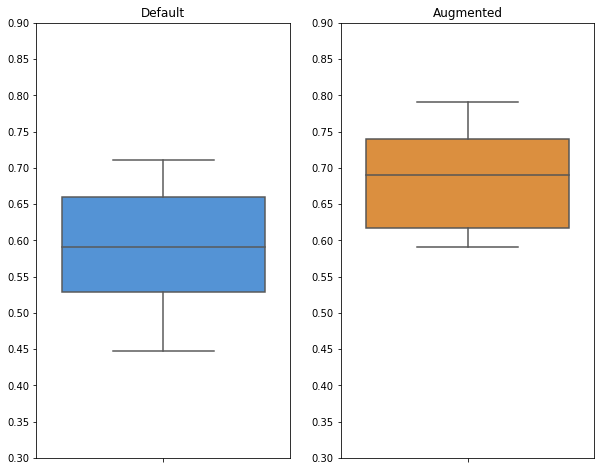

In [ ]:
classifier_names = ['Default', 'Augmented']
ACC = [default_accuracy, aug_accuracy]
c = ['#3f92eb', '#f59025']

f,axis = plt.subplots(1,2, figsize=(10,8))
for i in range(2):
  axis[i].set_ylim(0.3,0.9)
  axis[i].set_yticks([j for j in np.arange(0.3, 0.9, 0.05)])
  axis[i].title.set_text(classifier_names[i])
  sns.boxplot(ACC[i],ax=axis[i], orient='v', color = c[i])
# f.tight_layout(pad=3)